# Bach Chorales

## Imports

In [1]:
from IPython.utils import io
with io.capture_output() as captured:
  !pip install distrax
  !pip install numpyro
  !pip install optax

In [4]:
import jax

from jax import jit, lax, vmap
from jax.random import split, PRNGKey, permutation, normal
import jax.numpy as jnp
from jax.nn import log_softmax, sigmoid

import optax

import tensorflow as tf
import tensorflow_probability as tfp

import itertools


import distrax
from distrax import HMM

import numpy as np
import matplotlib.pyplot as plt

## Load Training Dataset

In [13]:
from numpyro.examples.datasets import JSB_CHORALES, load_dataset

_, fetch = load_dataset(JSB_CHORALES, split="train", shuffle=False)

lengths, sequences_all = fetch()

# find all the notes that are present at least once in the training set
present_notes = (sequences_all == 1).sum(0).sum(0) > 0
# remove notes that are never played (we remove 37/88 notes with default args)
sequences = sequences_all[:, :, present_notes]

print(sequences_all.shape)
print(sequences.shape)
print(lengths)

(229, 129, 88)
(229, 129, 51)
[129  65  49  65 114  33  57  49  64  33 108  48  49  48  61  48  65  53
  41  52  33  61  41  45  69  39  57  80  86  57  61 105  68  65  48  57
  57  52  48  33  93  41  65  49  73  48  33  45  65  52  49 109  49  52
  65  41  49  65  77  73  57  41  65  57  44  33  85  72  60  41  49  33
  56  52  56  83  57  57  52  41  53  64  61  65  65  48  25  96  41  37
  76  65  65  72  41  65  41  37  77  48  85  57  72  48  45  53  49  84
  68  49  73  50  96  55  66  98  37  76  65  33  49  77  76  65 128  41
  45  61  33  88  61  63  65  68  60  49  48  45  65  45  33  64  64  65
  49  63  61  48  45  65  84 120  41 102  49  57  69  57  82  48  76  48
  52 113  97  83  33  68  41  49  65 109 108  60  65  57  49  33  57  33
  61 113  58  64  65  33  57  49  64  68  60  65  41  72  53  49  57  33
  49  89  65  44  49  61  65  69  52  76  33  57  76  57  33  76 101  40
  41  44  76  65  49  54  49  49  64  51 109  65  65]


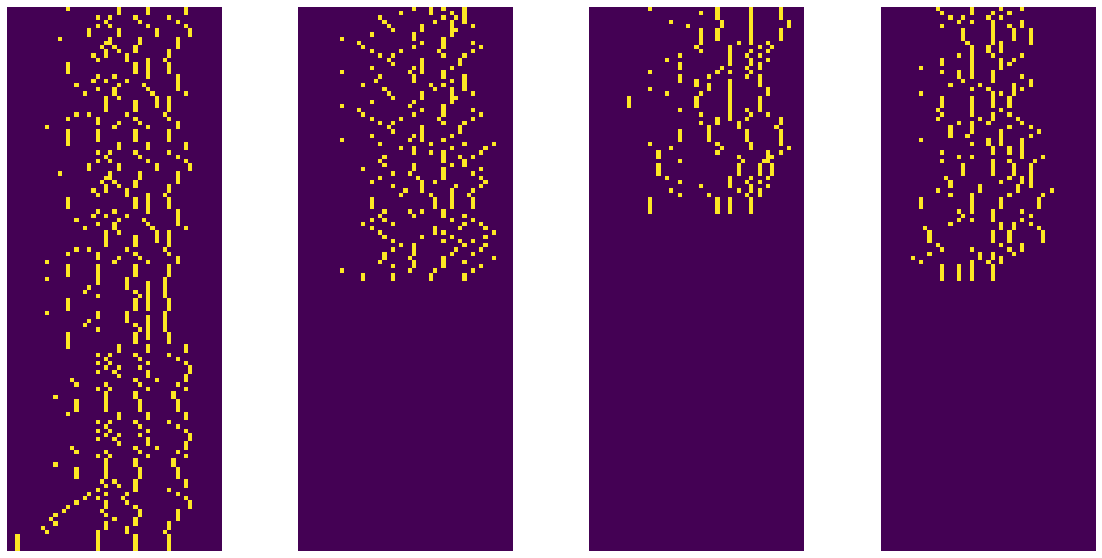

In [14]:
N = 4
fig, axs = plt.subplots(1, N, figsize=(20,10))
axs = axs.reshape(N)
for i in range(N):
  X = sequences[i,:,:].squeeze()
  ax = axs[i]
  ax.imshow(X)
  ax.set_axis_off()
plt.show()

## Gradient Descent

Creates mini-batches.

In [15]:
def hmm_sample_minibatches(iterables, batch_size):
    sequences, lens = iterables
    n_seq = len(sequences)
    for idx in range(0, n_seq, batch_size):
        yield sequences[idx:min(idx + batch_size, n_seq)], lens[idx:min(idx + batch_size, n_seq)]

In [25]:
def make_hmm(params):
    obs_logits, trans_logits = params
    trans_logits = log_softmax(trans_logits)

    obs_logits = jnp.clip(obs_logits, a_min=-12)
    trans_logits = jnp.clip(trans_logits, a_min=-12)

    b = distrax.Bernoulli(logits=obs_logits)
    obs_dist = distrax.Independent(b, 1)

    hmm = HMM(trans_dist= distrax.Categorical(logits=trans_logits),
                      obs_dist=obs_dist,
                      init_dist=distrax.Categorical(probs=initial_hmm.init_dist.probs))
    return hmm
  
@jit
def hmm_loglikelihood(hmm, observations, lens):
    def forward_(x, length):
      return hmm.forward(x, length)[0] / length
    return vmap(forward_, in_axes=(0, 0))(observations, lens)
    
@jit
def loss_fn(params, batch, lens):
    hmm = make_hmm(params)
    return -hmm_loglikelihood(hmm, batch, lens).mean()


def fit(observations, lens, beta, trans_dist,  batch_size,
        optimizer=optax.adam(1e-2), rng_key=None, num_epochs=300):
    
    if rng_key is None:
        rng_key = PRNGKey(0)

    initial_params = (beta.logits, trans_dist.logits)
    opt_state = optimizer.init(initial_params)
    itercount = itertools.count()

    num_complete_batches, leftover = jnp.divmod(num_epochs, batch_size)
    num_batches = num_complete_batches + jnp.where(leftover==0, 0, 1)

    def epoch_step(params_and_state, key):
        params, opt_state = params_and_state
        perm = permutation(key, len(observations))
        observatios_, lens_= observations[perm], lens[perm]
        sample_generator = hmm_sample_minibatches((observatios_, lens_), batch_size)
        
        def train_step(cur_params_and_state, i):
            params_i, state_i = cur_params_and_state
            batch, length = next(sample_generator)        
            
            loss, grads = jax.value_and_grad(loss_fn)(params_i, batch, length)
            updates, next_state = optimizer.update(grads, state_i)
            new_params = optax.apply_updates(params_i, updates)
            
            return (new_params, next_state), loss

        (params, opt_state), losses = jax.lax.scan(train_step,
                                                   (params, opt_state),
                                                   jnp.arange(num_batches))
        return (params, opt_state), losses.mean()

    epochs = split(rng_key, num_epochs)
    (params, opt_state), losses = jax.lax.scan(epoch_step,
                                     (initial_params, opt_state),
                                     epochs)

    losses = losses.flatten()

    hmm = make_hmm(params)
    obs_logits, _ = params
    return hmm, losses, obs_logits

## Initialize HMM

In [26]:
def init_hmm(K, D, initial_prob=0.1):
  trans_probs = distrax.as_distribution(tfp.substrates.jax.distributions.Dirichlet(0.9 * jnp.eye(K) + 0.1)).sample(seed=1)
  trans_dist = distrax.Categorical(probs=trans_probs)
  
  init_dist = distrax.Categorical(logits=jnp.zeros((K,)))
  
  b = distrax.Bernoulli(probs=jnp.full((K, D), initial_prob))
  obs_dist = distrax.Independent(b, 1)
  
  initial_hmm = HMM(trans_dist=trans_dist, obs_dist=obs_dist, init_dist=init_dist)
  return initial_hmm, b

In [27]:
K = 12
D = sequences.shape[2]
 
initial_hmm, b = init_hmm(K, D)

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:6461: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


## Determine Hyperparameters

In [28]:
num_epochs = 300 #@param {type:"slider", min:1, max:10000, step:0}
batch_size = 20 #@param {type:"slider", min:1, max:229, step:0}
learning_rate = 5e-2 #@param {type:"slider", min:0, max:1, step:0.01}

## Fit

In [32]:
optimizer = optax.adam(learning_rate)

hmm, losses, obs_logits = fit(sequences, lengths, b, initial_hmm.trans_dist, batch_size, optimizer=optimizer, num_epochs=num_epochs)

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:6461: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


## Loss Curve

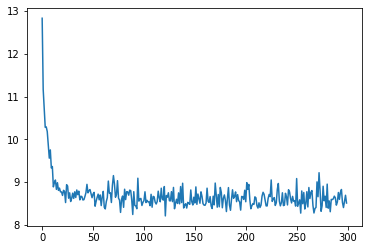

In [33]:
plt.plot(losses)
plt.show()

## Visualization of Parameters of HMM

### Observation Distribution

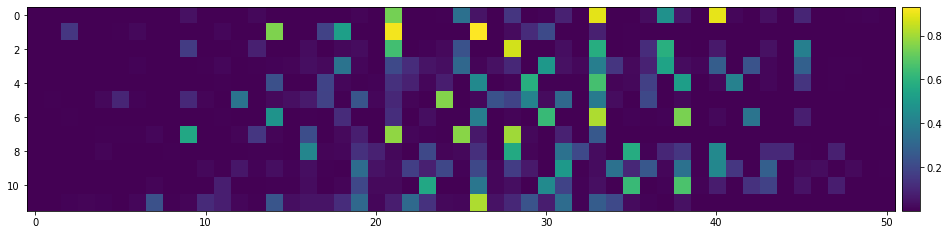

In [34]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.figure(figsize=(16, 16));
ax = plt.gca()
im = plt.imshow(sigmoid(obs_logits))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)

plt.colorbar(im, cax=cax);

### Transition Probabilities

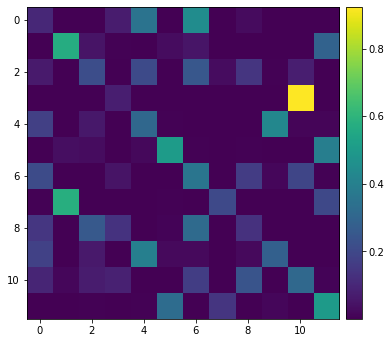

In [35]:
plt.figure(figsize=(6, 6));
ax = plt.gca()
im = plt.imshow(hmm.trans_dist.probs)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

plt.colorbar(im, cax=cax);

## Test

In [36]:
_, fetch = load_dataset(JSB_CHORALES, split="test", shuffle=False)

In [38]:
test_lengths, test_sequences = fetch()

# find all the notes that are present at least once in the training set
test_sequences = test_sequences[:, :, present_notes]

In [39]:
print('Test Negative Loglikelihood : ', -hmm_loglikelihood(hmm, test_sequences, test_lengths).mean()) # Test score

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:6461: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


Test Negative Loglikelihood :  8.835303


## Loss Curves of the Different Number of Hidden States and Batch Sizes

In [40]:
hidden_states = [3, 9, 16, 25] # Used in the paper 
batch_sizes = [1, 20, 229]

D = test_sequences.shape[2]
num_epochs = 200

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:6461: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")
/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:6461: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")
/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:6461: UserWarning

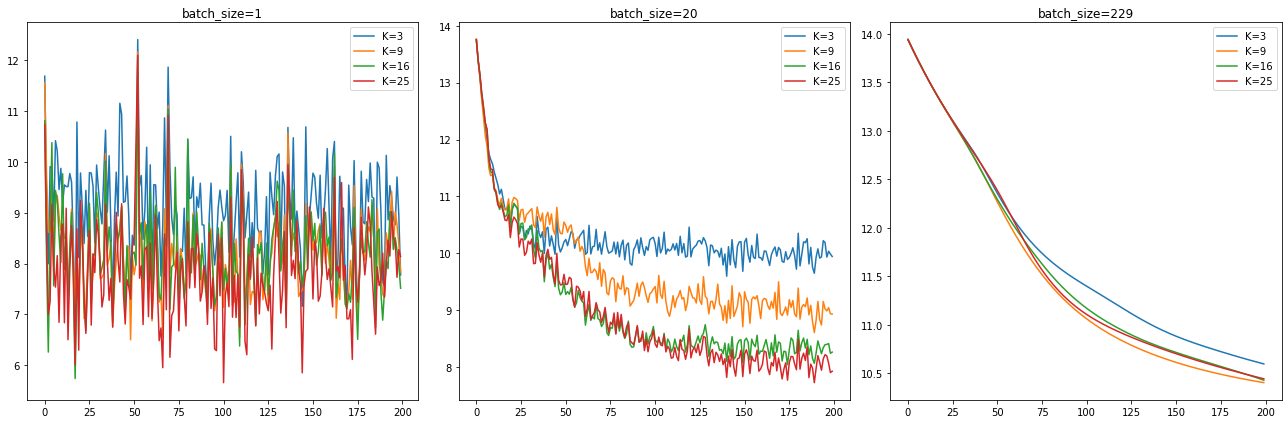

In [41]:
fig, axes = plt.subplots(nrows=1, ncols=len(batch_sizes))
axes = np.array(axes)

fig.set_figheight(6)
fig.set_figwidth(18)

for batch_size, ax in zip(batch_sizes, axes.flatten()):
  for k in hidden_states:
    initial_hmm, b = init_hmm(k, D)
    _, loss, _ = fit(sequences, lengths, b, initial_hmm.trans_dist, batch_size, num_epochs=num_epochs)
    ax.plot(loss, label=f'K={k}')
    
  ax.set_title(f'batch_size={batch_size}')
  ax.legend(loc='upper right')

fig.tight_layout()
plt.show()